# PicTex Text Detection Model

Len Huang. Given a square image of handwritten text, return its class.

### Step 1: Import Dataset

In [7]:
# from torchvision import datasets, transforms, models
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from PIL import Image

tqdm.pandas()

train_label = pd.read_csv("./dataset/fairface_label_train.csv", usecols=["file","gender","race"]).head()
test_label = pd.read_csv("./dataset/fairface_label_val.csv", usecols=["file","gender","race"]).head()

# Keep track of "None" images
train_missing, test_missing = [], []
def get_file(train):
    def test_file(file_name):
        try:
            img = Image.open(f"./dataset/images/{file_name}")
            return np.array(img)
        except:
            if train:
                train_missing.append(file_name)
            else:
                test_missing.append(file_name)
            return None
    return test_file

null_check = lambda x : x is not None
x_train = np.array(list(filter(null_check, list(train_label["file"].progress_map(get_file(True))))))
x_test = np.array(list(filter(null_check, list(test_label["file"].progress_map(get_file(False))))))

y_train = np.array(train_label["gender"] == "Male") * 1
y_test = np.array(train_label["gender"] == "Male") * 1

# G = Group
g_train = np.array(train_label["race"])
g_test = np.array(train_label["race"])

100%|██████████| 5/5 [00:00<00:00, 131.78it/s]

5
0
5
0


0


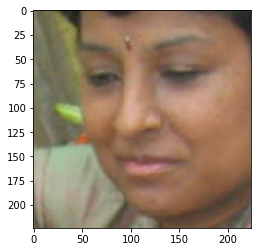

0


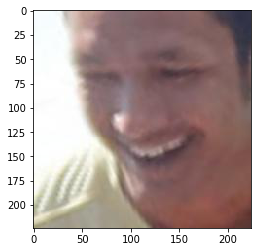

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(x_train[1])
print(y_train[1])
plt.show()
plt.imshow(x_test[4])
print(y_test[4])
plt.show()

### Step 2: Create CNN

https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2) # idk what this does
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Transitioning from Conv ===> Linear
        # 16 is the number of output channels in the previous conv layer.
        # not sure what 5 is...
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(classes))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# init the class 
model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=42, bias=True)
)


### Step 3: Loss Function and Optimizer

Adam/SGD and Cross Entrop Loss

In [4]:
import torch.optim as optim

# set parameters
learning_rate = 0.001
momentum = 0.9

def loss_optim():
    criterion = nn.CrossEntropyLoss()
    # Adam Max
    optimizer = torch.optim.Adamax(model.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    # Adam
    # optimizer = optim.Adam(model.parameters(), learning_rate)
    # SGD. Momentum = remembering previous estimation change for a param (delta W)
    # optimizer = optim.SGD(model.parameters(), learning_rate, momentum)
    return criterion, optimizer

criterion, optimizer = loss_optim()
print(criterion)
print(optimizer)

CrossEntropyLoss()
Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.002
    weight_decay: 0
)


### Step 4: Train Model

========================================BEGIN TRAINING=======================================
|  [Epoch: 1, Batch: 10]   Train loss: 0.629  |  Test loss: 3.689  |  Test accuracy: 0.078  |
|  [Epoch: 1, Batch: 20]   Train loss: 0.619  |  Test loss: 3.647  |  Test accuracy: 0.031  |
|  [Epoch: 1, Batch: 30]   Train loss: 0.600  |  Test loss: 3.501  |  Test accuracy: 0.094  |
|  [Epoch: 1, Batch: 40]   Train loss: 0.578  |  Test loss: 3.235  |  Test accuracy: 0.156  |
|  [Epoch: 1, Batch: 50]   Train loss: 0.548  |  Test loss: 3.079  |  Test accuracy: 0.250  |
|  [Epoch: 2, Batch: 10]   Train loss: 0.922  |  Test loss: 2.610  |  Test accuracy: 0.359  |
|  [Epoch: 2, Batch: 20]   Train loss: 0.470  |  Test loss: 2.713  |  Test accuracy: 0.312  |
|  [Epoch: 2, Batch: 30]   Train loss: 0.423  |  Test loss: 2.244  |  Test accuracy: 0.375  |
|  [Epoch: 2, Batch: 40]   Train loss: 0.416  |  Test loss: 2.663  |  Test accuracy: 0.312  |
|  [Epoch: 2, Batch: 50]   Train loss: 0.373  |  Test loss: 

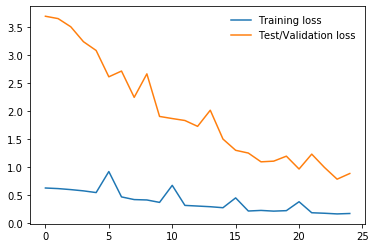

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

def train_network():
    
    # Choose parameters
    num_epoch = 5
    mini_batch = 10
    train_losses, test_losses = [], []
    running_loss = 0
    
    for epoch in range(num_epoch):  # loop over the dataset multiple times
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # print statistics
            if i % mini_batch == mini_batch - 1:    # print every # of mini-batches
                test_loss = 0
                accuracy = 0
                # begin evaluation of validation loss
                model.eval()
                with torch.no_grad():
                    for inputs_test, labels_test in testloader:
                        # GPU Optimization
                        # inputs, labels = inputs.to(device), labels.to(device)
                        logps = model.forward(inputs)
                        batch_loss = criterion(logps, labels)
                        test_loss += batch_loss.item()
                        ps = torch.exp(logps)
                        top_p, top_class = ps.topk(1, dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                train_losses.append(running_loss/len(trainloader))
                test_losses.append(test_loss/len(testloader))    
                print(f"|  [Epoch: {epoch + 1}, Batch: {i + 1}]   "
                      f"Train loss: {running_loss/len(trainloader):.3f}  |  "
                      f"Test loss: {test_loss/len(testloader):.3f}  |  "
                      f"Test accuracy: {accuracy/len(testloader):.3f}  |")
                running_loss = 0
                model.train()
            
    
    PATH = './models/pictex_text_detect.pth'
    torch.save(model.state_dict(), PATH)
    return train_losses, test_losses

def visualize_train(train_losses, test_losses):
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Test/Validation loss')
    plt.legend(frameon=False)
    plt.show()

print("========================================BEGIN TRAINING=======================================")
train_losses, test_losses = train_network()
print("=========================================END TRAINING========================================")
visualize_train(train_losses, test_losses)

### Step 5: Test the Network

https://stackoverflow.com/questions/13214809/pretty-print-2d-python-list

In [ ]:
import torchvision.utils as tvu


# Function to show an image
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy() # numpy-ify image
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Display Content in 8 rows 8 cols matrix
def display_class(labels):
    results = []
    for i in range(8):
        row = []
        for j in range(8):
            index = i + 1 * j
            prediction = classes[labels[index]]
            row.append(prediction)
        results.append(row)
    # Fancy code I found on StackOverflow
    s = [[str(e) for e in row] for row in results]
    lens = [max(map(len, col)) for col in zip(*s)]
    fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
    table = [fmt.format(*row) for row in s]
    print('\n'.join(table))
    
        

def test_data():
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # print images
    imshow(tvu.make_grid(images))
    display_class(labels)

test_data()